In [1]:
#| hide
%load_ext autoreload
%autoreload 2

# Math Changes for Shawn


In [2]:
#| default_exp pamm.bancor

In [3]:
#| export
import param as pm
import panel as pn
import pandas as pd
import numpy as np
import hvplot.pandas
import holoviews as hv

### Set up Types

In [4]:
# types

"""
Various Python types used in the model
"""


# Generic types
Uninitialized = np.nan
Percentage = float

# math spec conv types

# Dai = int
# xDai = int
# Dai_per_token = float
# tokens = int 

### Params

### Open questions to discuss with Shawn

* Think about fee ratio discuss with shawn: current idea was to pull a fee and gas fees before we use the invariant. so its taken from the delta R and then 
* Gas belonging to [gas min, gas max] monte carlo run
* leaving cost and the wedge discussion
* Does fee break Pamm??? --> ask jeff   Do we need fees in the primary ? 


* Will paribu wanna preinitialize into a discretionary treasury (non reserve spendable money)
* with theta 0 we assume everything goes to reserve 
* reserve ratio = R/S*price ??
* connector weight =  ??? and kappa relation 
* connector weight and reserve ratio !!
* https://medium.com/huobi-research/huobi-beyond-the-white-paper-vol-4-bancor-algorithm-mathematical-economic-analysis-3d91977b6de1#:~:text=In%20the%20above%20formula%2C%20CW,believe%20this%20formula%20is%20flawed.


## Hatch Params in BSCi Notation

In [6]:
# state variables

# S_supply = S0_initial_supply
# R_reserve = R0_initial_reserve


In [12]:

# Hatch params (stay const after hatch)

d0_initial_raise = 100 #(Dai) d0 must be between bounds of dmax dmin 
theta = 0 #must be between 0 and 1
kappa = 2 # bounds not sure need not be integer either right??
p0_hatch_sale_price = 1 #(dai per token)

R0_initial_reserve = (1-theta)*d0_initial_raise 
S0_initial_supply = d0_initial_raise/p0_hatch_sale_price # (tokens)
V0_power_function_invariant = (S0_initial_supply**kappa)/R0_initial_reserve # (tokens^kappa / dai)
p1_post_hatch_price = kappa*(1-theta)*p0_hatch_sale_price # (dai per token)
return_factor = kappa*(1-theta) # (dai per dai) p1/p0


# methods
def deposit_to_mint(delta_R, R_reserve, S_supply):
    ''' Deposit delta R to mint delta S'''
    delta_S = ((V0_power_function_invariant*(R_reserve+delta_R))**(1/kappa) - S_supply)
    return delta_S

def burn_to_withdraw(delta_S, R_reserve, S_supply):
    ''' Burn delta S to withdraw delta R'''
    delta_R = R_reserve - (((S_supply - delta_S)**kappa) / V0_power_function_invariant)
    return delta_R


def get_supply_from_reserve(R_reserve):
    '''get supply from new reserve value to conserve invariant'''
    return (R_reserve * V0_power_function_invariant)**(1/kappa)

def get_reserve_from_supply(S_supply):
    '''get reserve from new supply value to conserve invariant'''
    return S_supply**kappa / V0_power_function_invariant

def check_invariant(R_reserve, S_supply):
    '''check if invariant is conserved in current state'''
    return (S_supply**kappa)/R_reserve == V0_power_function_invariant

def realised_price(delta_R, delta_S):
    '''get realised price from delta R and delta S'''
    return delta_R/delta_S

def spot_price(R_reserve, S_supply):
    '''get spot price from current R and S which is a limit of realised price when delta R tends to zero'''
    return kappa*R_reserve**((kappa-1)/kappa)/V0_power_function_invariant**(1/kappa)



### Attempt to get it in Param class format (need your help here shawn)

In [13]:
import param as pm
# import matplotlib.pyplot as plt
import numpy as np

class BC(pm.Parameterized):
    d0_initial_raise = pm.Number(100, bounds=(1, None))  # (Dai) d0 must be between bounds of dmax dmin 
    theta = pm.Number(0.8, bounds=(0, 1))  # must be between 0 and 1
    kappa = pm.Number(2, bounds=(1, None))  # bounds not sure need not be integer either right??
    p0_hatch_sale_price = pm.Number(1, bounds=(0.01, None))  # (dai per token)

    R0_initial_reserve = pm.Number(constant=True)
    S0_initial_supply = pm.Number(constant=True)
    V0_power_function_invariant = pm.Number(constant=True)
    p1_post_hatch_price = pm.Number(constant=True)
    return_factor = pm.Number(constant=True)

    def __init__(self, **params):
        super().__init__(**params)
        self.update()

    @pm.depends('d0_initial_raise', 'theta', 'kappa', 'p0_hatch_sale_price', watch=True)
    def update(self):
        with pm.edit_constant(self):
            self.R0_initial_reserve = (1 - self.theta) * self.d0_initial_raise
            self.S0_initial_supply = self.d0_initial_raise / self.p0_hatch_sale_price
            self.V0_power_function_invariant = (self.S0_initial_supply ** self.kappa) / self.R0_initial_reserve
            self.p1_post_hatch_price = self.kappa * (1 - self.theta) * self.p0_hatch_sale_price
            self.return_factor = self.kappa * (1 - self.theta)

    def deposit_to_mint(self, delta_R, R_reserve, S_supply):
        ''' Deposit delta R to mint delta S'''
        delta_S = ((self.V0_power_function_invariant * (R_reserve + delta_R)) ** (1 / self.kappa) - S_supply)
        return delta_S

    def burn_to_withdraw(self, delta_S, R_reserve, S_supply):
        ''' Burn delta S to withdraw delta R'''
        delta_R = R_reserve - (((S_supply - delta_S) ** self.kappa) / self.V0_power_function_invariant)
        return delta_R

    def get_supply_from_reserve(self, R_reserve):
        return (R_reserve * self.V0_power_function_invariant) ** (1 / self.kappa)

    def get_reserve_from_supply(self, S_supply):
        return S_supply ** self.kappa / self.V0_power_function_invariant

    def check_invariant(self, R_reserve, S_supply):
        return (S_supply ** self.kappa) / R_reserve == self.V0_power_function_invariant

    def realised_price(self, delta_R, delta_S):
        return delta_R / delta_S

    def spot_price(self, R_reserve, S_supply):
        return self.kappa * R_reserve ** ((self.kappa - 1) / self.kappa) / self.V0_power_function_invariant ** (1 / self.kappa)
    
    def view_chart(self):
        delta_R_values = np.linspace(1, 100, 100)
        delta_S_values = np.linspace(1, 100, 100)

        realised_prices = [self.realised_price(delta_R, delta_S) for delta_R, delta_S in zip(delta_R_values, delta_S_values)]

        df = pd.DataFrame({
            'Delta R': delta_R_values,
            'Realised Price': realised_prices
        })

        return df.hvplot.line(x='Delta R', y='Realised Price', grid=True)

    def view(self):
        return pn.Row(self, self.view_chart)

In [14]:
b = BC()

In [15]:
b.view()

BokehModel(combine_events=True, render_bundle={'docs_json': {'a05b64fc-284b-489f-b51d-59692c2f76b2': {'version…

In [36]:
b.check_invariant(70, 100)

True

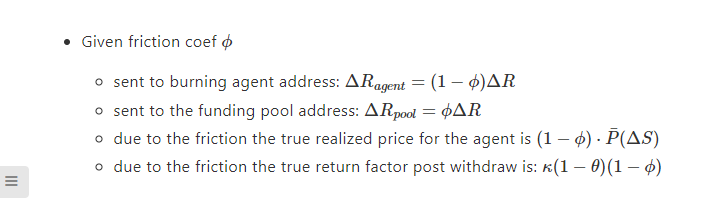

havent understood these yet ^^